In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
# from spikingjelly.clock_driven import functional, surrogate, neuron, layer
from spikingjelly.activation_based import functional, surrogate, neuron, layer, encoding
from torch.utils.data import DataLoader
import cupy
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
import os
import time
import argparse
from torch.cuda import amp
import sys
import datetime
from spikingjelly import visualizing

In [15]:
data_dir = './dataset/DVSgesture/'
frames_count = 16
train_set = DVS128Gesture(root=data_dir, train=True, data_type='frame',
                          frames_number=frames_count, split_by='number')
test_set = DVS128Gesture(root=data_dir, train=False, data_type='frame',
                         frames_number=frames_count, split_by='number')

Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\0].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\1].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\10].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\2].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\3].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\4].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\5].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\6].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\7].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\8].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\test\9].
Mkdir [./dataset/DVSgesture/frames_number_16_split_by_number\train].
Mkdir [./dataset/DVSgesture/f

In [16]:
T = frames_count
device = 'cuda:0'
b = 8
epochs = 40
out_dir = './dvsg/'
resume = False
j = 8
opt = 'adam'
momentum = 0.9
lr = 0.001
channels = 128
save_es = None

In [17]:
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=b,
    shuffle=True,
    drop_last=True,
    num_workers=j,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=b,
    shuffle=True,
    drop_last=False,
    num_workers=j,
    pin_memory=True
)

In [3]:
from copy import deepcopy
class DVSGestureNet(nn.Module):
    def __init__(self, channels=128, spiking_neuron: callable = None, **kwargs):
        super().__init__()

        conv = []
        for i in range(5):
            if conv.__len__() == 0:
                in_channels = 2
            else:
                in_channels = channels

            conv.append(layer.Conv2d(in_channels, channels,
                        kernel_size=3, padding=1, bias=False))
            conv.append(layer.BatchNorm2d(channels))
            conv.append(spiking_neuron(**deepcopy(kwargs)))
            conv.append(layer.MaxPool2d(2, 2))

        self.conv_fc = nn.Sequential(
            *conv,

            layer.Flatten(),
            layer.Dropout(0.5),
            layer.Linear(channels * 4 * 4, 512),
            spiking_neuron(**deepcopy(kwargs)),

            layer.Dropout(0.5),
            layer.Linear(512, 110),
            spiking_neuron(**deepcopy(kwargs)),

            layer.VotingLayer(10)
        )

    def forward(self, x: torch.Tensor):
        return self.conv_fc(x)

In [2]:
print(torch.cuda.is_available())

True


In [4]:
from torchinfo import summary
model = DVSGestureNet(channels=64, spiking_neuron=neuron.LIFNode,
                      surrogate_function=surrogate.ATan(), detach_reset=True).to('cuda')
summary(model, (8, 2, 128, 128), col_names=["input_size", "output_size","num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DVSGestureNet                            [8, 2, 128, 128]          [8, 11]                   --
├─Sequential: 1-1                        [8, 2, 128, 128]          [8, 11]                   --
│    └─Conv2d: 2-1                       [8, 2, 128, 128]          [8, 64, 128, 128]         1,152
│    └─BatchNorm2d: 2-2                  [8, 64, 128, 128]         [8, 64, 128, 128]         128
│    └─LIFNode: 2-3                      [8, 64, 128, 128]         [8, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                    [8, 64, 128, 128]         [8, 64, 64, 64]           --
│    └─Conv2d: 2-5                       [8, 64, 64, 64]           [8, 64, 64, 64]           36,864
│    └─BatchNorm2d: 2-6                  [8, 64, 64, 64]           [8, 64, 64, 64]           128
│    └─LIFNode: 2-7                      [8, 64, 64, 64]           [8, 64, 64, 64]           --
│    └─MaxPool2d: 2-8     

In [6]:
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(
    model, (2, 128, 128),  # Input shape (C, H, W)
    as_strings=False,
    print_per_layer_stat=True,
    verbose=True,
)
print(f"MACs: {macs/1e6:.2f} M")
print(f"FLOPs (≈ 2 × MACs): {macs * 2 / 1e6:.2f} MFLOPs")
print(f"Parameters: {params / 1e6:.2f} M")

DVSGestureNet(
  0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
  (conv_fc): Sequential(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (0): Conv2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=s)
    (1): BatchNorm2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=s)
    (2): LIFNode(
      0, 0.000% Params, 0.0 Mac, 0.000% MACs, v_threshold=1.0, v_reset=0.0, detach_reset=True, step_mode=s, backend=torch, tau=2.0
      (surrogate_function): ATan(0, 0.000% Params, 0.0 Mac, 0.000% MACs, alpha=2.0, spiking=True)
    )
    (3): MaxPool2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=s)
    (4): Conv2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=s)
    (5): BatchNorm2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 

In [22]:
import numpy as np
np.int = int
net = DVSGestureNet(channels=64, spiking_neuron=neuron.LIFNode, surrogate_function=surrogate.ATan(), detach_reset=True)

functional.set_step_mode(net, 'm')
functional.set_backend(net, 'cupy', instance=neuron.LIFNode)

print(net)
net.to(device)


scaler = torch.amp.GradScaler("cuda")

start_epoch = 0
max_test_acc = -1

optimizer = torch.optim.Adam(net.parameters(), lr=lr)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

# if args.resume:
#     checkpoint = torch.load(args.resume, map_location='cpu')
#     net.load_state_dict(checkpoint['net'])
#     optimizer.load_state_dict(checkpoint['optimizer'])
#     lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
#     start_epoch = checkpoint['epoch'] + 1
#     max_test_acc = checkpoint['max_test_acc']

out_dir = os.path.join(out_dir, f'T{T}_b{b}_{opt}_lr{lr}')


if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print(f'Mkdir {out_dir}.')

writer = SummaryWriter(out_dir, purge_step=start_epoch)
with open(os.path.join(out_dir, 'args.txt'), 'w', encoding='utf-8') as args_txt:
    # args_txt.write(str(args))
    args_txt.write('\n')
    args_txt.write(' '.join(sys.argv))

for epoch in range(start_epoch, epochs):
    start_time = time.time()
    net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    for frame, label in train_data_loader:
        optimizer.zero_grad()
        frame = frame.to(device)
        frame = frame.transpose(0, 1)  # [N, T, C, H, W] -> [T, N, C, H, W]
        label = label.to(device)
        label_onehot = F.one_hot(label, 11).float()

        if scaler is not None:
            with torch.amp.autocast(device_type=device):
                out_fr = net(frame).mean(0)
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = net(frame).mean(0)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        train_acc += (out_fr.argmax(1) == label).float().sum().item()

        functional.reset_net(net)

    train_time = time.time()
    train_speed = train_samples / (train_time - start_time)
    train_loss /= train_samples
    train_acc /= train_samples

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    lr_scheduler.step()

    net.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        for frame, label in test_data_loader:
            frame = frame.to(device)
            frame = frame.transpose(0, 1)
            label = label.to(device)
            label_onehot = F.one_hot(label, 11).float()
            out_fr = net(frame).mean(0)
            loss = F.mse_loss(out_fr, label_onehot)
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()
            test_acc += (out_fr.argmax(1) == label).float().sum().item()
            functional.reset_net(net)
    test_time = time.time()
    test_speed = test_samples / (test_time - train_time)
    test_loss /= test_samples
    test_acc /= test_samples
    writer.add_scalar('test_loss', test_loss, epoch)
    writer.add_scalar('test_acc', test_acc, epoch)

    save_max = False
    if test_acc > max_test_acc:
        max_test_acc = test_acc
        save_max = True

    checkpoint = {
        'net': net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch': epoch,
        'max_test_acc': max_test_acc
    }

    if save_max:
        torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_max.pth'))

    torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_latest.pth'))

    print(f'epoch = {epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}, max_test_acc ={max_test_acc: .4f}')
    print(f'train speed ={train_speed: .4f} images/s, test speed ={test_speed: .4f} images/s')



DVSGestureNet(
  (conv_fc): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (2): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=True, step_mode=m, backend=cupy, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (6): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=True, step_mode=m, backend=cupy, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (8): Conv2d(64,

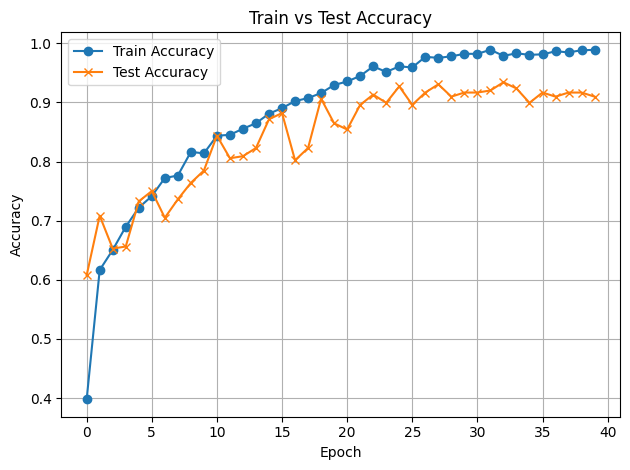

In [32]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# Path to the log folder for your run
log_path = './dvsg/T16_b8_adam_lr0.001'

event_acc = EventAccumulator(log_path)
event_acc.Reload()
train_acc_events = event_acc.Scalars('train_acc')
test_acc_events = event_acc.Scalars('test_acc')
train_loss_events = event_acc.Scalars('train_loss')
test_loss_events = event_acc.Scalars('test_loss')

train_epochs = [e.step for e in train_acc_events]
train_values = [e.value for e in train_acc_events]

test_epochs = [e.step for e in test_acc_events]
test_values = [e.value for e in test_acc_events]

plt.figure()
plt.plot(train_epochs, train_values, label='Train Accuracy', marker='o')
plt.plot(test_epochs, test_values, label='Test Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

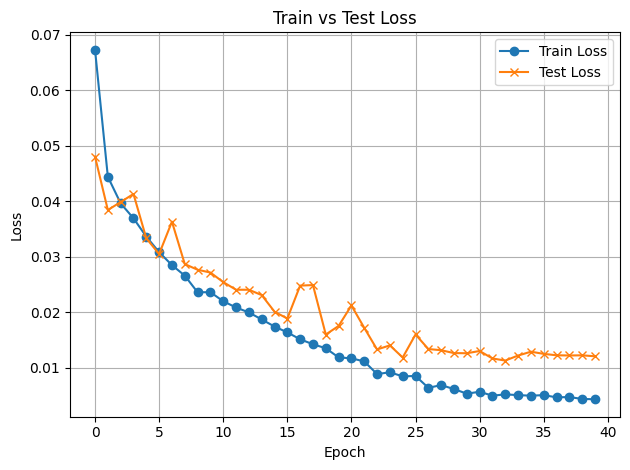

In [34]:
train_loss_events = event_acc.Scalars('train_loss')
test_loss_events = event_acc.Scalars('test_loss')

train_epochs = [e.step for e in train_loss_events]
train_values = [e.value for e in train_loss_events]

test_epochs = [e.step for e in test_loss_events]
test_values = [e.value for e in test_loss_events]

plt.figure()
plt.plot(train_epochs, train_values, label='Train Loss', marker='o')
plt.plot(test_epochs, test_values, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()